<a href="https://colab.research.google.com/github/HaeChanBong/HaeChanBong.github.io/blob/master/Zero_shot_segmentation_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP (Zero-shot segmentation)

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/ricardodeazambuja/CLIP.git@attn_weights
! pip install umap-learn
! pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ricardodeazambuja/CLIP.git (to revision attn_weights) to /tmp/pip-req-build-0fgw0nsk
  Running command git clone --filter=blob:none --quiet https://github.com/ricardodeazambuja/CLIP.git /tmp/pip-req-build-0fgw0nsk
  Running command git checkout -b attn_weights --track origin/attn_weights
  Switched to a new branch 'attn_weights'
  Branch 'attn_weights' set up to track remote branch 'attn_weights' from 'origin'.
  Resolved https://github.com/ricardodeazambuja/CLIP.git to commit 376a231cb9433b1086689466ca893852d708195b
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
from pkg_resources import packaging
import umap
import hdbscan
import os
print("Torch version:", torch.__version__)

Torch version: 1.13.1+cu116


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

clip.available_models()

['ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

Model stats for ViT-B/32
- output_embed_dim: 512
- vision_width: 768
- vision_layers: 12
- vision_patch_size: 32
- vision_heads: 12
- grid_size: 7
- image_resolution: 224
- context_length: 77
- vocab_size: 49408
- transformer_width: 512
- transformer_heads: 8
- transformer_layers: 12
- total number of parameters: 151,277,313


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fc47f2f2c10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [7]:
from PIL import Image
from PIL.Image import FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import interpolate

from torchvision.transforms.functional import to_tensor, normalize, gaussian_blur

# Clustering

Load dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -uq "/content/drive/My Drive/suadd_23_input_images-v0.1" -d "/content/drive/My Drive/DS"
train_image_path = '/content/drive/My Drive/DS/train' 
test_image_path = '/content/drive/My Drive/DS/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Group clusters.
def grp(images, labels):
    # Holds the cluster id and the images { id: [images] }
    groups = {}
    for file, cluster in zip(images, labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)

    return groups

In [10]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = train_grp[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 15:
        print(f"Clipping cluster size from {len(files)} to 15")
        files = files[:14]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model stats for ViT-B/32
- output_embed_dim: 512
- vision_width: 768
- vision_layers: 12
- vision_patch_size: 32
- vision_heads: 12
- grid_size: 7
- image_resolution: 224
- context_length: 77
- vocab_size: 49408
- transformer_width: 512
- transformer_heads: 8
- transformer_layers: 12
- total number of parameters: 151,277,313
6
-1
Clipping cluster size from 25 to 15
0
1
Clipping cluster size from 30 to 15
2
3
4
Clipping cluster size from 1689 to 15


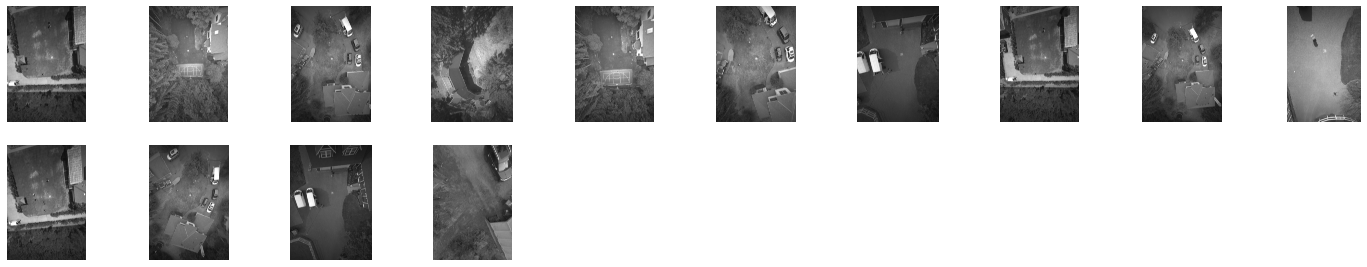

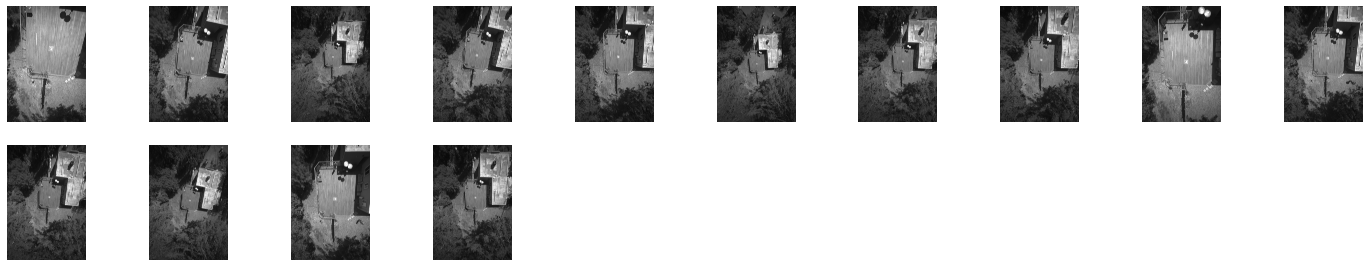

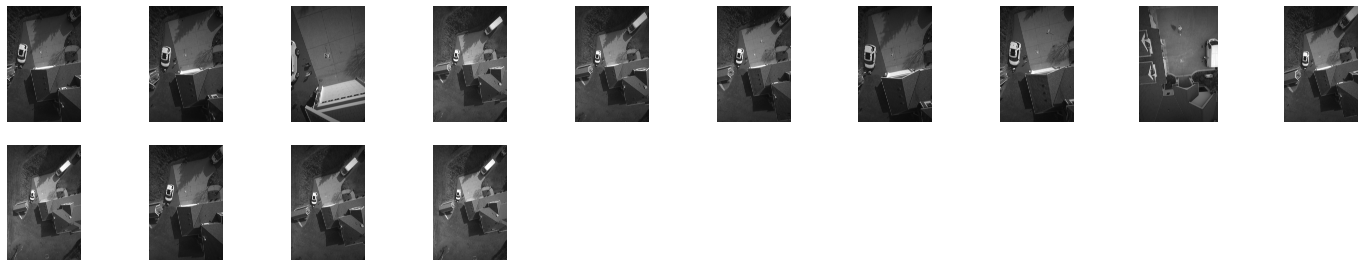

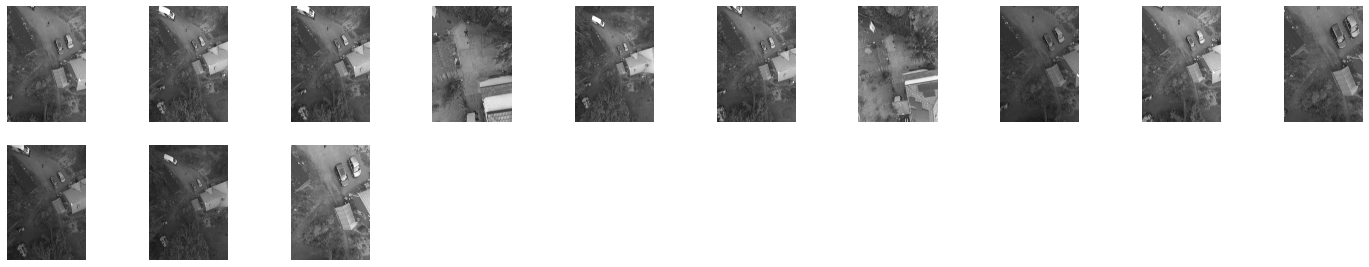

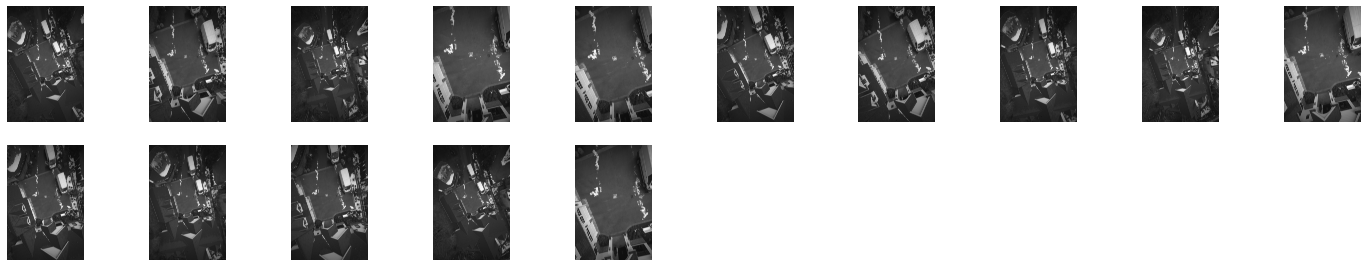

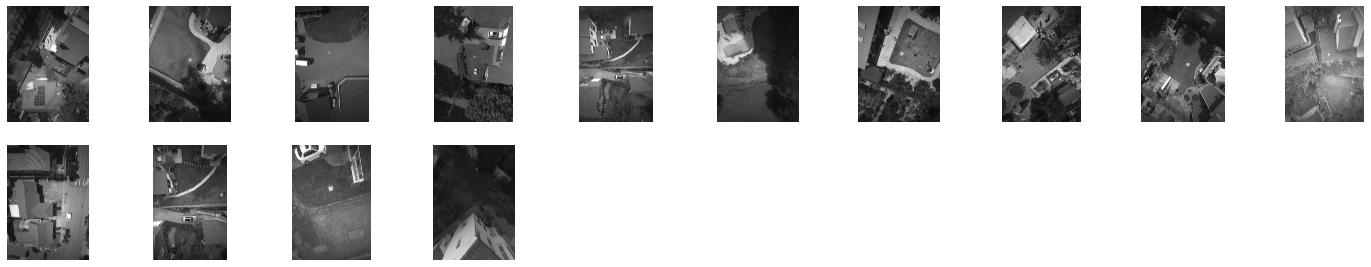

In [11]:
!pip install keras
import torch
import numpy as np
import torchvision.transforms as T
from PIL import Image
import umap
import hdbscan
import os
import keras
from tensorflow.keras.utils import load_img

# Load pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32")

# Set UMAP parameters
n_neighbors = 15
min_dist = 0.1
n_components = 2

# Set HDBSCAN parameters
min_cluster_size = 10

# Load images and extract features
features = []
images = []

train_image_path = '/content/drive/My Drive/DS/inputs' 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.chdir(train_image_path)
with os.scandir(train_image_path) as files:
    for file in files:
        images.append(file.name)
        image = Image.open(file.path)
        image = image.convert('RGB') # Convert to RGB if necessary
        image_input = preprocess(image).unsqueeze(0).to(device) # Move tensor to the same device as the model
        with torch.no_grad():
            feature, w = model.encode_image(image_input)
            feature = feature.to('cpu') # Move the tensor back to the CPU
            features.append(feature)

# Convert features to numpy array and reduce dimensionality with UMAP
features_np = np.array([feature.numpy() for feature in features])
features_np = np.squeeze(features_np, axis=1)  # Remove the extra dimension
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
embedding = reducer.fit_transform(features_np)

# Cluster using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
cluster_labels = clusterer.fit_predict(embedding)

train_grp = grp(images, cluster_labels)
unique_labels = np.unique(cluster_labels)
print(len(unique_labels))

for label in unique_labels:
    print(label)
    view_cluster(label)